In [1]:
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import IFrame
from sklearn.cluster import KMeans
import matplotlib.font_manager as fm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, Circle, Arc

#plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
sc_params = {u'AheadBehind': u'',
 u'ClutchTime': u'',
 u'ContextFilter': u'',
 u'ContextMeasure': u'FGA',
 u'DateFrom': u'',
 u'DateTo': u'',
 u'EndPeriod': u'',
 u'EndRange': u'',
 u'GameID': u'',
 u'GameSegment': u'',
 u'LastNGames': 0,
 u'LeagueID': u'00',
 u'Location': u'',
 u'Month': 0,
 u'OpponentTeamID': 0,
 u'Outcome': u'',
 u'Period': 0,
 u'PlayerID': 0,
 u'PointDiff': u'',
 u'Position': u'',
 u'RangeType': u'',
 u'RookieYear': u'',
 u'Season': u'2015-16',
 u'SeasonSegment': u'',
 u'SeasonType': u'Regular Season',
 u'StartPeriod': u'',
 u'StartRange': u'',
 u'TeamID': 0,
 u'VsConference': u'',
 u'VsDivision': u''}

baseurl = 'http://stats.nba.com/stats/shotchartdetail?'
resp2 = requests.get(baseurl,params=sc_params)
print resp2.url
jdata = resp2.json()

http://stats.nba.com/stats/shotchartdetail?PlayerID=0&StartPeriod=&StartRange=&TeamID=0&VsConference=&Location=&SeasonType=Regular+Season&RangeType=&RookieYear=&Season=2015-16&DateFrom=&ClutchTime=&EndPeriod=&EndRange=&ContextFilter=&GameID=&OpponentTeamID=0&DateTo=&GameSegment=&AheadBehind=&PointDiff=&LastNGames=0&VsDivision=&LeagueID=00&Position=&Outcome=&ContextMeasure=FGA&SeasonSegment=&Period=0&Month=0


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [4]:
import mechanize
br = mechanize.Browser()
import cookielib
cj = cookielib.LWPCookieJar()
br.set_cookiejar(cj)
br.set_handle_equiv(True)
br.set_handle_gzip(True)
br.set_handle_redirect(True)
br.set_handle_referer(True)
br.set_handle_robots(False)
br.set_handle_refresh(mechanize._http.HTTPRefreshProcessor(), max_time=1)
br.addheaders = [('User-agent', 'Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9.0.1) Gecko/2008071615 Fedora/3.0.1-1.fc9 Firefox/3.0.1')]
data = br.open(resp2.url).get_data()

import json
jdata = json.loads(data)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: UserWarning: gzip transfer encoding is experimental!


In [5]:
player_shot_df = pd.DataFrame(jdata['resultSets'][0]['rowSet'],columns=jdata['resultSets'][0]['headers'])
print player_shot_df.shape
player_shot_df.head(5)

(125400, 21)


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Shot Chart Detail,0021500001,2,203083,Andre Drummond,1610612765,Detroit Pistons,1,11,41,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-17,-6,1,0
1,Shot Chart Detail,0021500001,5,202694,Marcus Morris,1610612765,Detroit Pistons,1,11,21,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,13,117,67,1,1
2,Shot Chart Detail,0021500001,6,200794,Paul Millsap,1610612737,Atlanta Hawks,1,11,0,Made Shot,Step Back Jump shot,2PT Field Goal,In The Paint (Non-RA),Right Side(R),8-16 ft.,12,76,95,1,1
3,Shot Chart Detail,0021500001,7,203484,Kentavious Caldwell-Pope,1610612765,Detroit Pistons,1,10,44,Made Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Left Side(L),8-16 ft.,8,-68,51,1,1
4,Shot Chart Detail,0021500001,8,201143,Al Horford,1610612737,Atlanta Hawks,1,10,27,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,20,-117,164,1,0


In [6]:
xyfields = ['LOC_X','LOC_Y']
keepfields = ['LOC_X','LOC_Y','SHOT_ZA_ZR']
player_shot_df = player_shot_df.assign(SHOT_ZA_ZR = player_shot_df['SHOT_ZONE_AREA'] + ' ' + player_shot_df['SHOT_ZONE_RANGE'])
ZA_ZR_dict={'Back Court(BC) Back Court Shot':0, u'Center(C) 16-24 ft.':7,
       u'Center(C) 24+ ft.':12, u'Center(C) 8-16 ft.':3,
       u'Center(C) Less Than 8 ft.':1, u'Left Side Center(LC) 16-24 ft.':8,
       u'Left Side Center(LC) 24+ ft.':13, u'Left Side(L) 16-24 ft.':9,
       u'Left Side(L) 24+ ft.':14, u'Left Side(L) 8-16 ft.':4,
       u'Right Side Center(RC) 16-24 ft.':6, u'Right Side Center(RC) 24+ ft.':11,
       u'Right Side(R) 16-24 ft.':5, u'Right Side(R) 24+ ft.':10,
       u'Right Side(R) 8-16 ft.':2}
player_shot_df['SHOT_ZA_ZR_num']=player_shot_df['SHOT_ZA_ZR'].map(lambda x: ZA_ZR_dict[x])
shot_za_zr_centroids = player_shot_df[keepfields].groupby('SHOT_ZA_ZR').mean()
#shot_za_zr_centroids.assign(SHOT_ZA_ZR = SHOT_ZONE_AREA + ' ' + SHOT_ZONE_RANGE)
#shot_za_zr_centroids.as_matrix()[:
shot_za_zr_centroids

,LOC_X,LOC_Y
SHOT_ZA_ZR,,
Back Court(BC) Back Court Shot,16.189831,530.203390
Center(C) 16-24 ft.,1.181859,187.164560
Center(C) 24+ ft.,2.007849,249.719914
Center(C) 8-16 ft.,1.456410,115.811355
Center(C) Less Than 8 ft.,-0.322087,13.991551
Left Side Center(LC) 16-24 ft.,-111.363731,151.218197
Left Side Center(LC) 24+ ft.,-160.410925,193.038147
Left Side(L) 16-24 ft.,-175.202770,45.311818
Left Side(L) 24+ ft.,-234.930050,12.938113


In [7]:
def left_court_patches(clr='red',zo=0):
    # creates the patches for the left hand side of an nba court
    # returns: list of patches with
    # 1.0 = 1 foot
    # 0,0 in lower left corner 
    # 5.25,-25 is center of rim circle (left side rim)
    rim = Circle((5.25,-25),radius=.75, color=clr, zorder=zo, lw=.5, fill=False)
    bkbrd = Rectangle((4,-28),width=0, height=6, color=clr, zorder=zo,fill=False,lw=1.5)
    ra_arc = Arc((5.25,-25),8,8,theta1=270,theta2=90,color=clr,zorder=zo,fill=False,lw=1.5)
    ra_t = Rectangle((4,-21),width=1.25,height=0,color=clr, zorder=zo,fill=False,lw=1.5)
    ra_b = Rectangle((4,-29),width=1.25,height=0,color=clr, zorder=zo,fill=False,lw=1.5)
    ft = Rectangle((0,-33),width=19,height=16,color=clr, zorder=zo,fill=False,lw=1.5) #*16ft. outside
    lane = Rectangle((0,-31),width=19,height=12,color=clr,zorder=zo,fill=False,lw=1.5)#*12ft. outside
    ft_ia = Arc((19,-25),12,12,theta1=90,theta2=270,color=clr,zorder=zo,fill=False,lw=1.5,linestyle='--')
    ft_oa = Arc((19,-25),12,12,theta1=270,theta2=90,color=clr,zorder=zo,fill=False,lw=1.5)
    three_t = Rectangle((0,-3),width=14,height=0,color=clr,zorder=zo,fill=False,lw=1.5)
    three_b = Rectangle((0,-47),width=14,height=0,color=clr,zorder=zo,fill=False,lw=1.5)
    three_arc = Arc((5.25,-25),23.75*2,23.75*2,theta1=292,theta2=68,color=clr,zorder=zo,fill=False,lw=1.5)
    return [rim,bkbrd,ra_arc,ra_t,ra_b,ft,lane,ft_ia,ft_oa,three_t,three_b,three_arc]

def draw_half_court(ax=None,clr='red',zo=0):
    # Draws half court onto axis 0,0 is center of rim
    # returns: axis
    if ax is None:
        ax = plt.gca()
        
    left_patches = left_court_patches(clr=clr,zo=zo)
    #translate left patches
    # rotate pi/2 around center (5.25,-25), translate new center to 0,0, scale by 10
    tr = mpl.transforms.Affine2D().rotate_around(5.25,-25,np.pi/2).translate(-5.25,25).scale(10) + ax.transData
    for patch in left_patches:
        patch.set_transform(tr)
        ax.add_patch(patch)
    return ax

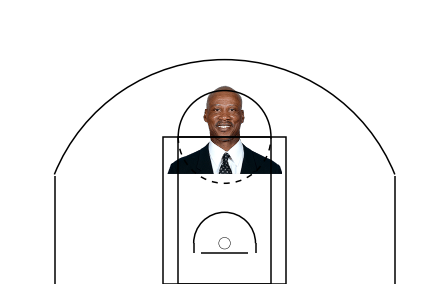

In [8]:
from StringIO import StringIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def get_player_230x185png(pID=None):
    if pID is None:
        raise ValueError("Input 'pID' to get_player_img is None. Requires int")
    img_url = 'http://stats.nba.com/media/players/230x185/%i.png' % pID
    response = requests.get(img_url)
    if response.status_code == 200:
        player_img = plt.imread(StringIO(response.content))
        return player_img
    else:
        raise ValueError("Could not get image from %s" % img_url)


def plot_player_img(img=None,x=0,y=0,ax=None,zoom=.5,zo=1):
    if ax is None:
        ax = plt.gca()
    im = OffsetImage(img,zoom=zoom,zorder=zo)
    ab = AnnotationBbox(im, (x,y), xycoords='data', frameon=False)
    ab.set_zorder(zo)
    ax.add_artist(ab)
    return ax
    
#layername='Stephen Curry'
#ID = player_shot_df[player_shot_df['PLAYER_NAME']==playername]['PLAYER_ID'].iloc[0]
#player_img = get_player_230x185png(pID)

player_img = get_player_230x185png(2)

fig,ax = plt.subplots(figsize=(6,6))

ax = plot_player_img(player_img,x=0,y=150,ax=ax,zo=3)
ax = draw_half_court(clr='k',ax=ax,zo=4)
ax.set_xlim(-250,250)
ax.set_ylim(-52.5,300)
ax.grid('off')
ax.set_aspect('equal')
ax.set_axis_off()

plt.tight_layout()
plt.show()

Yeah, 'coach' Byron Scott is image 2.png for some reason. 3.png is the NBA logo, above and below those values was nothing. I like it.

Center(C) 16-24 ft.              PLAYER_ID  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG    FG_PCT
PLAYER_NAME                                                          
Pau Gasol         2200                  110              50  0.454545
Serge Ibaka     201586                   87              47  0.540230
Center(C) 24+ ft.                PLAYER_ID  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG    FG_PCT
PLAYER_NAME                                                            
James Harden      201935                  124              51  0.411290
Stephen Curry     201939                  106              49  0.462264
Center(C) 8-16 ft.                PLAYER_ID  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG    FG_PCT
PLAYER_NAME                                                            
Brook Lopez       201572                  102              44  0.431373
DeMar DeRozan     201942                   88              44  0.500000
Center(C) Less Than 8 ft.                 PLAYER_ID  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLA

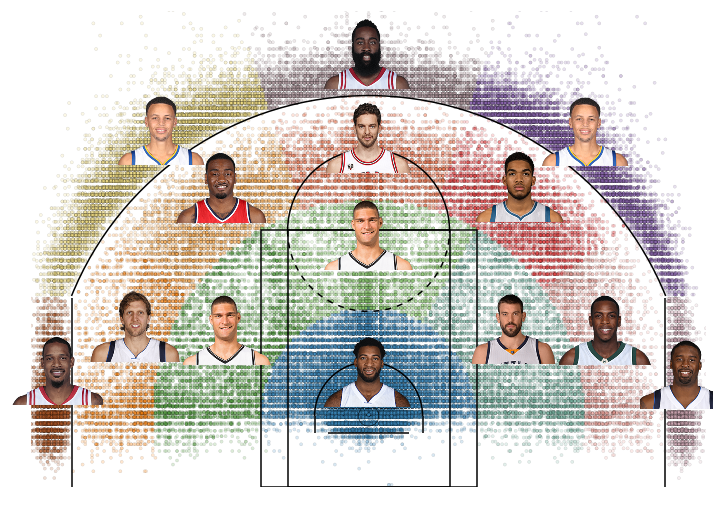

In [9]:
fig,ax = plt.subplots(figsize=(10,10))
ax = draw_half_court(clr='k',ax=ax,zo=0)
ax.scatter(x=player_shot_df.LOC_X,y=player_shot_df.LOC_Y,s=10,
            c=player_shot_df.SHOT_ZA_ZR_num.astype(np.float),cmap=plt.cm.Paired,
            alpha=.2,zorder=0,label=None)
#S
#Filter for each zone
SHOT_THRESH = 20
keep_cols = ['PLAYER_ID','PLAYER_NAME','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG','SHOT_ZA_ZR']
for z in shot_za_zr_centroids.index[1:]:
    #plot all shots in the zone
    
    #filter for zone & groupby playerID
    group_shot_z_df = player_shot_df[player_shot_df['SHOT_ZA_ZR']==z][keep_cols].groupby('PLAYER_NAME').sum()
    #compute pct
    group_shot_z_df = group_shot_z_df.assign(FG_PCT = group_shot_z_df['SHOT_MADE_FLAG'] / group_shot_z_df['SHOT_ATTEMPTED_FLAG'])
    #normalize PLAYER_ID to get the true value
    group_shot_z_df['PLAYER_ID']=group_shot_z_df['PLAYER_ID']/group_shot_z_df['SHOT_ATTEMPTED_FLAG']
    #filter for shot attempts and sort by selected column
    #top_shot_z_df = group_shot_z_df[group_shot_z_df['SHOT_ATTEMPTED_FLAG']>SHOT_THRESH].sort_values('FG_PCT',ascending=False)
    top_shot_z_df = group_shot_z_df[group_shot_z_df['SHOT_ATTEMPTED_FLAG']>SHOT_THRESH].sort_values('SHOT_MADE_FLAG',ascending=False)
    print z, top_shot_z_df.head(2)
    player_img = get_player_230x185png(top_shot_z_df['PLAYER_ID'].iloc[0])
    #p=re.compile(r'C\)\ \+24ft\.')
    #m = p.search(z)
    if z.find('C) 24+ ft.'):
        mod_y = 20
        #zo = 0
    else:
        mod_y = 0
        #zo = 4
    #print shot_za_zr_centroids.loc[z]['LOC_X']
    ax = plot_player_img(player_img,x=-shot_za_zr_centroids.loc[z]['LOC_X'],y=shot_za_zr_centroids.loc[z]['LOC_Y']+mod_y,ax=ax,zoom=.4)
    
    #print top_shot_z_df.head(5)



#groupby playerID



#get top, place image at centroid of region
ax.set_xlim(-250,250)
ax.set_ylim(-52.5,300)
ax.grid('off')
ax.set_aspect('equal')
ax.set_axis_off()

plt.tight_layout()
plt.show()



In [ ]:
plt.style.use('fivethirtyeight')
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))

#Plot all shots
draw_half_court(clr='k',ax=ax1)
ax1.scatter(x=player_shot_df.LOC_X,y=player_shot_df.LOC_Y,s=10,
            c=player_shot_df.SHOT_ZA_ZR_num.astype(np.float),cmap=plt.cm.Paired,
            alpha=.2,zorder=0,label=None)
#Set custom cluster centroids (or zone centroids) and plot
#clust_cent = np.array([[-230,0],[-150,0],[-120,150],[0,0],[-180,180],[0,180],[0,250],[120,150],[180,180],[150,0],[230,0]])
#ax1.scatter(clust_cent[:,0],clust_cent[:,1],s=50,color='r',label='manual centroids')
#Plot zone area, zone range centroids in yellow
ax1.scatter(shot_za_zr_centroids.as_matrix()[1:,0],shot_za_zr_centroids.as_matrix()[1:,1],
            s=50,color='yellow',label='zone area/range centroids')
ax1.set_xlim(-250,250)
ax1.set_ylim(-52.5,300)
ax1.grid('off')
ax1.set_aspect('equal')
ax1.set_axis_off()
ax1.set_title('All shots')
ax1.legend(loc=2)


xyfields = ['LOC_X','LOC_Y']
all_shot_df = player_shot_df[xyfields]

clust_cent = np.array([[-150,0],[-120,150],[0,0],[0,180],[120,150],[150,0],[-230,0],[-180,180],[0,250],[180,180],[230,0]])
#clust_cent = shot_za_zr_centroids.as_matrix()[1:,:]

kmeansall = KMeans(init=clust_cent,n_clusters=len(clust_cent),n_init=1)
kmeansall.fit(all_shot_df)
#print kmeansall.cluster_centers_

draw_half_court(clr='k',ax=ax2)
ax2.scatter(all_shot_df['LOC_X'],all_shot_df['LOC_Y'],alpha=.2,s=10,
            c=kmeansall.labels_.astype(np.float),cmap=plt.cm.Paired)
ax2.scatter(kmeansall.cluster_centers_[:,0],kmeansall.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
clust_cent = np.array([[-230,0],[-150,0],[-120,150],[0,0],[-180,180],[0,180],[0,250],[120,150],[180,180],[150,0],[230,0]])
ax2.scatter(clust_cent[:,0],clust_cent[:,1],s=50,color='r')
ax2.set_xlim(-250,250)
ax2.set_ylim(-52.5,300)
ax2.grid('off')
ax2.set_aspect('equal')
ax2.set_axis_off()
ax2.set_title('Manual Centroid K-Means')

#Use centroids of zone area/range labels for kmeans
clust_cent = shot_za_zr_centroids.as_matrix()[1:,:]
kmeansall = KMeans(init=clust_cent,n_clusters=len(clust_cent),n_init=1)
kmeansall.fit(all_shot_df)
#print kmeansall.cluster_centers_
#Plot results
draw_half_court(clr='k',ax=ax3)
ax3.scatter(all_shot_df['LOC_X'],all_shot_df['LOC_Y'],alpha=.2,s=10,c=kmeansall.labels_.astype(np.float),cmap=plt.cm.Paired)
ax3.scatter(kmeansall.cluster_centers_[:,0],kmeansall.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
ax3.scatter(shot_za_zr_centroids.as_matrix()[1:,0],shot_za_zr_centroids.as_matrix()[1:,1],
            s=50,color='yellow')
ax3.set_xlim(-250,250)
ax3.set_ylim(-52.5,300)
ax3.grid('off')
ax3.set_aspect('equal')
ax3.set_axis_off()
ax3.set_title('Zone Area/Range Centroid K-Means')


twoPT_shot_df = player_shot_df.loc[player_shot_df['SHOT_TYPE']=='2PT Field Goal',xyfields]
clust_cent = np.array([[-150,0],[-120,150],[0,0],[0,180],[120,150],[150,0]])
#clust_cent = shot_za_zr_centroids.as_matrix()[[1,3,4,5,7,8,10,12,14],:]

kmeans = KMeans(init=clust_cent,n_clusters=len(clust_cent),n_init=1)
kmeans.fit(twoPT_shot_df)
#print kmeans.cluster_centers_

draw_half_court(clr='k',ax=ax4)
ax4.scatter(twoPT_shot_df['LOC_X'],twoPT_shot_df['LOC_Y'],alpha=.2,s=10,c=kmeans.labels_.astype(np.float),cmap=plt.cm.Paired)
ax4.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
ax4.scatter(clust_cent[:,0],clust_cent[:,1],s=50,color='r')
ax4.set_xlim(-250,250)
ax4.set_ylim(-52.5,300)
ax4.grid('off')
ax4.set_aspect('equal')
ax4.set_axis_off()
ax4.set_title('2-pt. Manual Centroid K-Means')


plt.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans
xyfields = ['LOC_X','LOC_Y']
all_shot_df = player_shot_df[xyfields]

clust_cent = np.array([[-150,0],[-120,150],[0,0],[0,180],[120,150],[150,0],[-230,0],[-180,180],[0,250],[180,180],[230,0]])
clust_cent = shot_za_zr_centroids.as_matrix()[1:,:]

kmeansall = KMeans(init=clust_cent,n_clusters=len(clust_cent),n_init=1)
kmeansall.fit(all_shot_df)
print kmeansall.cluster_centers_

plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize=(12, 12))
draw_half_court(clr='k')
plt.scatter(all_shot_df['LOC_X'],all_shot_df['LOC_Y'],alpha=.2,s=10,c=kmeansall.labels_.astype(np.float),cmap=plt.cm.Paired)
plt.xlim(-250,250)
plt.ylim(-52.5,400)
plt.scatter(kmeansall.cluster_centers_[:,0],kmeansall.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
plt.show()

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans
xyfields = ['LOC_X','LOC_Y']
twoPT_shot_df = player_shot_df.loc[player_shot_df['SHOT_TYPE']=='2PT Field Goal',xyfields]

clust_cent = np.array([[-150,0],[-120,150],[0,0],[0,180],[120,150],[150,0]])
clust_cent = shot_za_zr_centroids.as_matrix()[[1,3,4,5,7,8,10,12,14],:]

kmeans = KMeans(init=clust_cent,n_clusters=len(clust_cent),n_init=1)
kmeans.fit(twoPT_shot_df)
print kmeans.cluster_centers_

plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize=(8, 8))
draw_half_court(clr='k',ax=ax)
ax.scatter(twoPT_shot_df['LOC_X'],twoPT_shot_df['LOC_Y'],alpha=.2,s=10,c=kmeans.labels_.astype(np.float),cmap=plt.cm.Paired)
ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
ax.set_xlim(-250,250)
ax.set_ylim(-52.5,300)
ax.grid('off')
ax.set_aspect('equal')
ax.set_axis_off()
plt.show()

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans
xyfields = ['LOC_X','LOC_Y']
threePT_shot_df = player_shot_df.loc[player_shot_df['SHOT_TYPE']=='3PT Field Goal',xyfields]

clust_cent = np.array([[-230,0],[-200,150],[0,250],[200,150],[230,0]])
clust_cent = shot_za_zr_centroids.as_matrix()[[0,2,6,8,11,13],:]

kmeans3pt = KMeans(init=clust_cent,n_clusters=len(clust_cent),n_init=1)
kmeans3pt.fit(threePT_shot_df)
print kmeans3pt.cluster_centers_

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8, 6))
plt.scatter(threePT_shot_df['LOC_X'],threePT_shot_df['LOC_Y'],alpha=.2,s=10,c=kmeans3pt.labels_.astype(np.float),cmap=plt.cm.Paired)
plt.xlim(-250,250)
plt.ylim(-52.5,400)
plt.scatter(kmeans3pt.cluster_centers_[:,0],kmeans3pt.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
plt.show()

In [ ]:
xyfields = ['LOC_X','LOC_Y','SHOT_ZONE_AREA']
threePT_shot_df = player_shot_df.loc[player_shot_df['SHOT_TYPE']=='3PT Field Goal',xyfields]

#create a lookup dict for the zone areas to turn them into ints
za_codes={'Right Side(R)':0,'Right Side Center(RC)':1,'Center(C)':2,
          'Left Side Center(LC)':3,'Left Side(L)':4,'Back Court(BC)':5}
threePT_shot_df['ZA_num']=threePT_shot_df['SHOT_ZONE_AREA'].map(lambda x: za_codes[x])

#plot 3pt shots colored by zone area
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8, 6))
plt.scatter(threePT_shot_df['LOC_X'],threePT_shot_df['LOC_Y'],alpha=.2,s=10,
            c=threePT_shot_df['ZA_num'].astype(np.float),cmap=plt.cm.Paired)
plt.xlim(-250,250)
plt.ylim(-52.5,400)
#plt.scatter(kmeans3pt.cluster_centers_[:,0],kmeans3pt.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
plt.show()

In [ ]:
shot_za_

In [ ]:
from matplotlib.patches import Rectangle, Circle, Arc
from matplotlib.collections import PatchCollection
import matplotlib as mpl

def left_court_patches(clr='red',zo=0):
    # creates the patches for the left hand side of an nba court
    # returns: list of patches with
    # 0,0 in lower left corner, center 
    # 5.25,-25 is center of rim circle (left side rim)
    rim = Circle((5.25,-25),radius=.75, color=clr, zorder=zo, lw=.5, fill=False)
    bkbrd = Rectangle((4,-28),width=0, height=6, color=clr, zorder=zo,fill=False,lw=1)
    ra_arc = Arc((5.25,-25),8,8,theta1=270,theta2=90,color=clr,zorder=zo,fill=False,lw=1)
    ra_t = Rectangle((4,-21),width=1.25,height=0,color=clr, zorder=zo,fill=False,lw=1)
    ra_b = Rectangle((4,-29),width=1.25,height=0,color=clr, zorder=zo,fill=False,lw=1)
    ft = Rectangle((0,-33),width=19,height=16,color=clr, zorder=zo,fill=False,lw=1) #*16ft. outside
    lane = Rectangle((0,-31),width=19,height=12,color=clr,zorder=zo,fill=False,lw=1)#*12ft. outside
    ft_ia = Arc((19,-25),12,12,theta1=90,theta2=270,color=clr,zorder=zo,fill=False,lw=1,linestyle='--')
    ft_oa = Arc((19,-25),12,12,theta1=270,theta2=90,color=clr,zorder=zo,fill=False,lw=1)
    three_t = Rectangle((0,-3),width=14,height=0,color=clr,zorder=zo,fill=False,lw=1)
    three_b = Rectangle((0,-47),width=14,height=0,color=clr,zorder=zo,fill=False,lw=1)
    three_arc = Arc((5.25,-25),23.75*2,23.75*2,theta1=292,theta2=68,color=clr,zorder=zo,fill=False,lw=1)
    return [rim,bkbrd,ra_arc,ra_t,ra_b,ft,lane,ft_ia,ft_oa,three_t,three_b,three_arc]

def draw_half_court(ax=None,clr='red',zo=0):
    # Draws half court onto axis 0,0 is center of rim
    # returns: axis
    if ax is None:
        ax = plt.gca()
        
    left_patches = left_court_patches(clr=clr,zo=zo)
    #translate left patches
    # rotate pi/2 around center (5.25,-25), translate new center to 0,0, scale by 10
    tr = mpl.transforms.Affine2D().rotate_around(5.25,-25,np.pi/2).translate(-5.25,25).scale(10) + ax.transData
    for patch in left_patches:
        patch.set_transform(tr)
        ax.add_patch(patch)
    return ax

plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize=(9,9))

draw_half_court(clr='k')
ax.scatter(threePT_shot_df['LOC_X'],threePT_shot_df['LOC_Y'],alpha=.2,s=10,
            c=threePT_shot_df['ZA_num'].astype(np.float),cmap=plt.cm.Paired)
plt.xlim(-250,250)
plt.ylim(-52.5,400)
#plt.scatter(kmeans3pt.cluster_centers_[:,0],kmeans3pt.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
ax.set_aspect('equal')
#plt.axis('equal')
#plt.xlim(-250,250)
#plt.ylim(-52.5,400)
#plt.axis([-250,250,-52.5,400])

plt.show()

In [ ]:
ZAs = player_shot_df.SHOT_ZONE_AREA.unique()
ZRs = player_shot_df.SHOT_ZONE_RANGE.unique()[:-1] #-1 to avoid Backcourt shots

fig,ax = plt.subplots(figsize=(12, 12))
colrs = np.random.random((len(ZAs)*len(ZRs),4))
cmap = plt.get_cmap()
print cmap.N
cnum=0
for za in ZAs:
    for zr in ZRs:
        bin_mask = (player_shot_df['SHOT_ZONE_AREA']==za) & (player_shot_df['SHOT_ZONE_RANGE']==zr)
        if np.sum(bin_mask) > 0:
            cnum+=1
            plt.scatter(x=player_shot_df[bin_mask]['LOC_X'],y=player_shot_df[bin_mask]['LOC_Y'],c=colrs[cnum],
             s=5, alpha=.7, edgecolors='none', zorder=2,label=za+zr)
ax.invert_yaxis()

#Read in the half court image
plt.style.use('grayscale')
court = plt.imread("img/halfcourt.png")
#The baseline is 4 ft. from front of backboard. front of backboard is 15 in. from center of hoop (the origin).
#Therefore, my image extent needs to go from (4ft.+15in.) = 5.25 ft. so 52.5 ft. in the coordinate system.
img = plt.imshow(court, zorder=0, extent=[-250,250,420,-52.5])
plt.title('All NBA Shots Attempts by Shot Zone and Range 2015-16',fontsize='x-large')
plt.savefig('img/NBA_shotzonerange_2015-16.png',dpi=300)
plt.show